# Drone Swarm Simulation Analysis

This notebook analyzes the output CSV file generated by the drone swarm simulation. It performs the following steps:
1. **Load Data**: Reads parameters and step-by-step simulation data from the CSV file.
2. **Preprocess Data**: 
    - Separates simulation parameters from the main dataset.
    - Converts relevant columns to appropriate numeric types.
    - Filters for edges that are susceptible to Electronic Warfare (`is_ew_susceptible == True`).
    - Calculates a 'link_quality' metric as `1 - ew_effect`.
3. **Visualize Data**: 
    - Plots the `link_quality` of susceptible edges over simulation `steps`.
    - Each susceptible edge is represented by a distinct colored line.

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io # For reading the mixed-format CSV

# seaborn style
sns.set_context("talk")


## 1. Load Data

First, we need to specify the path to the CSV file generated by the simulation.

In [81]:
csv_filepath = 'swarm_simulation_log.csv'

In [82]:
def load_simulation_data(filepath):
    """Loads parameters and step data from the simulation CSV file."""
    parameters = {}
    data_lines = []
    
    with open(filepath, 'r') as f:
        reading_params = True
        header_line = None
        for line in f:
            line = line.strip()
            if not line: # Blank line separates parameters from data header
                reading_params = False
                continue
            
            if reading_params:
                if ',' in line:
                    parts = line.split(',', 1)
                    if len(parts) == 2:
                        key, value = parts
                        # Attempt to convert known numeric/boolean parameters
                        if value.lower() == 'true':
                            parameters[key] = True
                        elif value.lower() == 'false':
                            parameters[key] = False
                        elif value.startswith('(') and value.endswith(')'):
                             # Handle tuples like (1050.0, 0.0)
                            try:
                                parameters[key] = eval(value) # Use eval carefully
                            except:
                                parameters[key] = value # Keep as string if eval fails
                        else:
                            try:
                                parameters[key] = float(value)
                            except ValueError:
                                parameters[key] = value # Keep as string if not float
            else:
                if header_line is None:
                    header_line = line
                    data_lines.append(header_line)
                else:
                    data_lines.append(line)
                    
    if not data_lines:
        raise ValueError("No data found after parameters in the CSV file.")
        
    # Convert data lines to DataFrame
    data_io = io.StringIO('\n'.join(data_lines))
    df = pd.read_csv(data_io)
    
    return parameters, df

# Load the data
try:
    sim_params, sim_df = load_simulation_data(csv_filepath)
    print("Simulation Parameters:")
    for key, value in sim_params.items():
        print(f"  {key}: {value}")
    print("\nFirst 5 rows of Simulation Data:")
    print(sim_df.head())
except FileNotFoundError:
    print(f"Error: The file '{csv_filepath}' was not found. Please check the path.")
except ValueError as e:
    print(f"Error processing the CSV file: {e}")
    

Simulation Parameters:
  Parameter: Value
  network_capacity_type: MEDIUM
  LINK_LENGTH_METERS: 25.0
  relay_connectivity_config: CROSS_ROW
  ew_disruption_percentage: 0.3
  ew_location: "(1050.0, 0.0)"
  ew_strength_factor: 100000.0
  ew_disable_threshold: 0.8
  start_point: "(0.0, 0.0)"
  end_point: "(1000.0, 0.0)"
  step_size_m: 10.0
  max_steps: 200.0
  logging_enabled: True
  csv_output_enabled: True
  csv_filename: swarm_simulation_log.csv

First 5 rows of Simulation Data:
   step  leader_pos_x  leader_pos_y  connected_drones_count edge_u edge_v  \
0     1          10.0           0.0                      13     M1     R1   
1     1          10.0           0.0                      13     M1     R2   
2     1          10.0           0.0                      13     M1     R3   
3     1          10.0           0.0                      13     M1     R4   
4     1          10.0           0.0                      13     R1     S1   

   is_active  current_capacity  is_ew_susceptible  ew

## 2. Preprocess Data

Now, we will prepare the data for plotting:
- Ensure correct data types for relevant columns.
- Filter for EW susceptible edges.
- Create the `link_quality` column.

In [83]:
if 'sim_df' in locals(): # Check if DataFrame was loaded successfully
    # Correct data types if necessary (pandas often infers them well from CSV)
    sim_df['step'] = pd.to_numeric(sim_df['step'])
    sim_df['ew_effect'] = pd.to_numeric(sim_df['ew_effect'])
    sim_df['is_ew_susceptible'] = sim_df['is_ew_susceptible'].astype(bool)

    # Filter for EW susceptible edges
    susceptible_df = sim_df[sim_df['is_ew_susceptible'] == True].copy() # Use .copy() to avoid SettingWithCopyWarning

    # Calculate 'link_quality'
    susceptible_df['link_quality'] = 1 - susceptible_df['ew_effect']
    
    # Create a unique identifier for each edge to use in plotting
    # Sorting u and v ensures that (A,B) is treated the same as (B,A) if data isn't consistently ordered
    susceptible_df['edge_pair'] = susceptible_df.apply(lambda row: tuple(sorted((row['edge_u'], row['edge_v']))), axis=1)
    susceptible_df['edge_label'] = susceptible_df.apply(lambda row: f"{row['edge_u']}-{row['edge_v']}", axis=1)

    print("\nFirst 5 rows of Preprocessed Susceptible Edges Data:")
    print(susceptible_df.head())
else:
    print("DataFrame 'sim_df' not loaded. Cannot preprocess.")
    


First 5 rows of Preprocessed Susceptible Edges Data:
    step  leader_pos_x  leader_pos_y  connected_drones_count edge_u edge_v  \
1      1          10.0           0.0                      13     M1     R2   
7      1          10.0           0.0                      13     R2     S3   
10     1          10.0           0.0                      13     R3     A1   
12     1          10.0           0.0                      13     R4     A3   
15     2          20.0           0.0                      13     M1     R2   

    is_active  current_capacity  is_ew_susceptible  ew_effect  link_quality  \
1        True     906553.382898               True   0.093447      0.906553   
7        True     903462.979482               True   0.096537      0.903463   
10       True     911456.820199               True   0.088543      0.911457   
12       True     911417.603363               True   0.088582      0.911418   
15       True     904720.299285               True   0.095280      0.904720   

  

## 3. Visualize Data

Let's plot the `link_quality` against `step` for each susceptible edge.

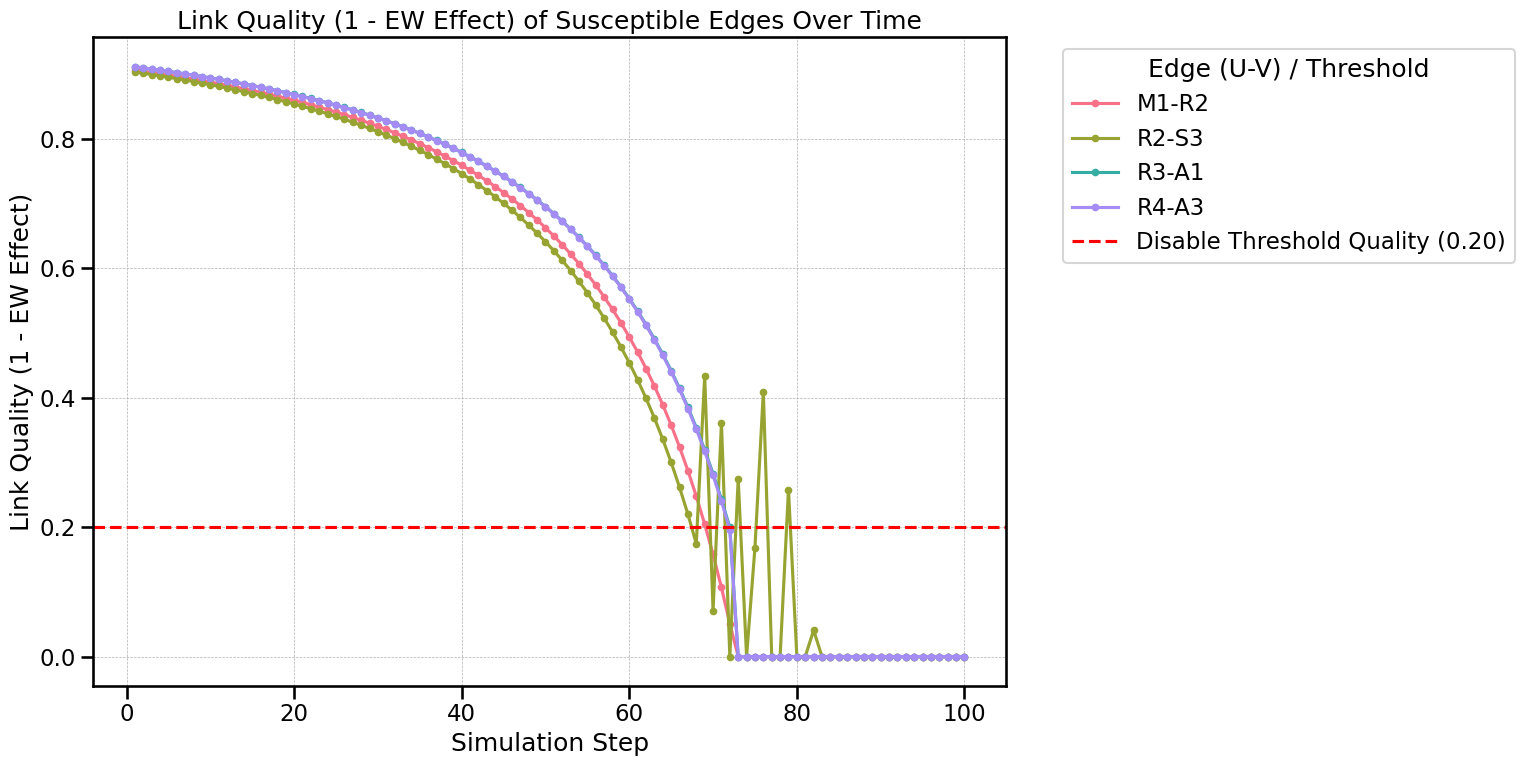

In [84]:
if 'susceptible_df' in locals() and not susceptible_df.empty:
    plt.figure(figsize=(15, 8))
    
    # Use seaborn for easier plotting with different colors per edge
    # Plotting each edge individually to ensure consistent coloring and legend if seaborn hue struggles with many categories
    unique_edges = susceptible_df['edge_label'].unique()
    palette = sns.color_palette('husl', n_colors=len(unique_edges)) # Get a diverse color palette
    
    for i, edge in enumerate(unique_edges):
        edge_data = susceptible_df[susceptible_df['edge_label'] == edge]
        plt.plot(edge_data['step'], edge_data['link_quality'], marker='.', linestyle='-', label=edge, color=palette[i])

    plt.title('Link Quality (1 - EW Effect) of Susceptible Edges Over Time')
    plt.xlabel('Simulation Step')
    plt.ylabel('Link Quality (1 - EW Effect)')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(title='Edge (U-V)', bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside plot
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
    
    # Add a horizontal line for the EW disable threshold (on the ew_effect scale, so 1 - threshold for link_quality)
    if 'ew_disable_threshold' in sim_params:
        disable_quality_threshold = 1 - sim_params['ew_disable_threshold']
        plt.axhline(y=disable_quality_threshold, color='r', linestyle='--', label=f'Disable Threshold Quality ({disable_quality_threshold:.2f})')
        # Re-draw legend to include the new line if added after initial legend call
        plt.legend(title='Edge (U-V) / Threshold', bbox_to_anchor=(1.05, 1), loc='upper left')
        
    plt.show()
else:
    print("No susceptible edge data to plot or 'susceptible_df' not created.")
    